In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 127.5 - 1.0  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension

BUFFER_SIZE = 60000
BATCH_SIZE = 256
LATENT_DIM = 100  # Size of the random noise vector

# Create batches of data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [3]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, input_dim=LATENT_DIM))
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), activation='tanh', strides=1, padding='same'))
    return model

In [4]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=2, padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [5]:
generator = build_generator()
discriminator = build_discriminator()

# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [6]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [7]:
EPOCHS = 50

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [8]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)

        print(f'Epoch {epoch+1}/{epochs}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}')

        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1)

In [9]:
def generate_and_save_images(model, epoch, test_input=None):
    if test_input is None:
        test_input = tf.random.normal([16, LATENT_DIM])

    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch}.png')
    plt.close()

# Start training the model
train(train_dataset, EPOCHS)

c:\Users\DELL\anaconda3\envs\deep\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/50, Gen Loss: 1.565866470336914, Disc Loss: 0.6763666868209839
Epoch 2/50, Gen Loss: 3.1118648052215576, Disc Loss: 0.14529332518577576
Epoch 3/50, Gen Loss: 4.572444915771484, Disc Loss: 0.03718334808945656
Epoch 4/50, Gen Loss: 3.2348127365112305, Disc Loss: 0.13392126560211182
Epoch 5/50, Gen Loss: 4.987726211547852, Disc Loss: 0.02469561994075775
Epoch 6/50, Gen Loss: 3.1647543907165527, Disc Loss: 0.09895134717226028
Epoch 7/50, Gen Loss: 3.2707204818725586, Disc Loss: 0.12693478167057037
Epoch 8/50, Gen Loss: 3.699047327041626, Disc Loss: 0.07047871500253677
Epoch 9/50, Gen Loss: 3.3946077823638916, Disc Loss: 0.14331109821796417
Epoch 10/50, Gen Loss: 5.017736434936523, Disc Loss: 0.02270427718758583
Epoch 11/50, Gen Loss: 5.458872318267822, Disc Loss: 0.0084476163610816
Epoch 12/50, Gen Loss: 3.2408812046051025, Disc Loss: 0.12731176614761353
Epoch 13/50, Gen Loss: 3.5061733722686768, Disc Loss: 0.2912716269493103
Epoch 14/50, Gen Loss: 3.1584277153015137, Disc Loss: 0.

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def test_and_display(real_image, generator, noise_dim=100):
    # Generate a fake image from random noise
    noise = np.random.randn(1, noise_dim)
    generated_image = generator.predict(noise)
    
    # Rescale generated image to [0, 1] (for visualization)
    generated_image = 0.5 * generated_image + 0.5
    
    # Plot real and generated image side by side
    plt.figure(figsize=(6, 3))
    
    # Real image
    plt.subplot(1, 2, 1)
    plt.imshow(real_image.squeeze(), cmap='gray')
    plt.title("Real Image")
    plt.axis('off')
    
    # Generated image
    plt.subplot(1, 2, 2)
    plt.imshow(generated_image.squeeze(), cmap='gray')
    plt.title("Generated Image")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 19ms/step


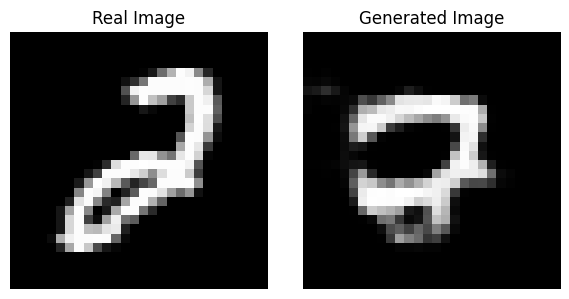

In [47]:
test_and_display(x_train[555], generator, noise_dim=100)

1/1 [==============================] - 0s 18ms/step


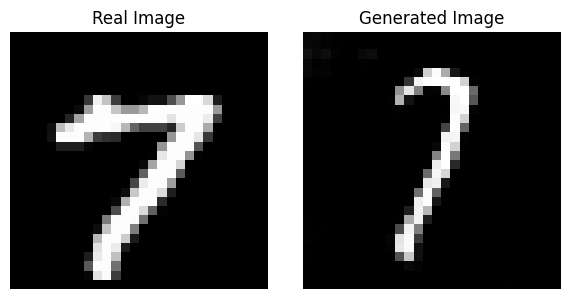

In [32]:
test_and_display(x_train[5555], generator, noise_dim=100)

1/1 [==============================] - 0s 18ms/step


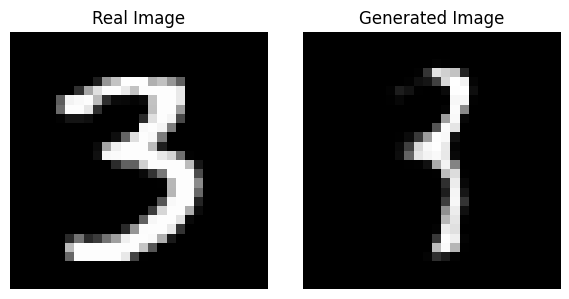

In [85]:
test_and_display(x_train[10000], generator, noise_dim=100)